In [204]:
import pandas as pd
import numpy as np
import math 
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import average_precision_score as precision
import seaborn as sns

In [28]:
#Données de base
#datedecreationdecommande,  providerservice_id ,   dateexpe
#2019-11-01 11:40:35.9930000 ,   48,   02/11/2019

In [29]:
#Données qu'on va rajouter  
#Année, mois, jour, jour de la semaine,mois de l'année, heure, providerservice_id, datexpédition, 
#délai entre commande et expédition, commande passé en période fête, commande passé le week-end, 
#commande passé en dehors des heures de travails [8 heure, 19 heures]

In [93]:
#Lecture du CSV
df = pd.read_csv('logistique.csv',parse_dates=['datedecreationdecommande'])

In [94]:
#Affichage du dataset
df

,datedecreationdecommande,providerservice_id,dateexpe
0,2019-11-01 11:40:35.993,48,02/11/2019
1,2019-11-01 11:40:35.970,48,02/11/2019
2,2019-11-01 10:24:40.893,48,02/11/2019
3,2019-11-01 14:24:21.177,48,02/11/2019
4,2019-11-01 13:28:35.790,48,02/11/2019
...,...,...,...
572836,2019-12-16 06:12:25.217,48,17/12/2019
572837,2019-12-16 06:12:25.463,48,17/12/2019
572838,2019-12-15 22:32:36.320,48,17/12/2019
572839,2019-12-15 20:06:55.067,48,17/12/2019


In [95]:
df.dtypes

datedecreationdecommande    datetime64[ns]
providerservice_id                   int64
dateexpe                            object
dtype: object

In [96]:
#Conversion des features datedecreationdecommande et dateexpe en string pour effectuer des modifications
df["datedecreationdecommande"] = df["datedecreationdecommande"].astype(str)

#On simplifie le format de la feature dateCreationdecommande pour simplifier le traitement
df["datedecreationdecommande"] = df["datedecreationdecommande"].str.replace('-','/')

In [97]:
#Création de nouvelle colonne à partir de la feature datedecreationdecommande -> Year, month, day, hour
df["year"] = pd.to_datetime(df['datedecreationdecommande'],format='%Y/%m/%d').dt.year
df["month"] = pd.to_datetime(df['datedecreationdecommande'],format='%Y/%m/%d').dt.month
df["day"] = pd.to_datetime(df['datedecreationdecommande'],format='%Y/%m/%d').dt.day
df["hour"] = pd.to_datetime(df['datedecreationdecommande'],format='%Y/%m/%d %H:%M').dt.hour
df["min"] = pd.to_datetime(df['datedecreationdecommande'],format='%Y/%m/%d %H:%M').dt.minute

#Création d'une nouvelle colonne day_of_week, qui permet d'avoir le jour de la semaine lundi ou mardi etc...
df['day_of_week'] = pd.to_datetime(df['datedecreationdecommande'],format='%Y/%m/%d %H:%M').dt.dayofweek

In [98]:
#On affecte le type dateTime au colonne dateCreationdecommande et dateexpe pour simplifier le traitement
df["datedecreationdecommande"] = df["datedecreationdecommande"].str[0:10]
df['datedecreationdecommande'] = pd.to_datetime(df['datedecreationdecommande'],format='%Y/%m/%d')
df["dateexpe"] = pd.to_datetime(df['dateexpe'],format='%d/%m/%Y')

In [99]:
df.head()

,datedecreationdecommande,providerservice_id,dateexpe,year,month,day,hour,min,day_of_week
0,2019-11-01,48,2019-11-02,2019,11,1,11,40,4
1,2019-11-01,48,2019-11-02,2019,11,1,11,40,4
2,2019-11-01,48,2019-11-02,2019,11,1,10,24,4
3,2019-11-01,48,2019-11-02,2019,11,1,14,24,4
4,2019-11-01,48,2019-11-02,2019,11,1,13,28,4


In [100]:
#On crée une nouvelle colonne pour avoir le délai entre la date de création de la commande et son expédition
df['délai'] = df['dateexpe'] - df['datedecreationdecommande']
df["délai"] = df["délai"].astype(str)
df["délai"] = df["délai"].str[0:2].astype(int)

In [101]:
#On crée une nouvelle colonne pour savoir si la commande a été passé le week-end
df["isWeekend"] =  np.where(df["day_of_week"] < 5, 1, 0)

In [102]:
df["isOnWorkShift"] =  np.where((df["hour"] <= 18) & (df["min"] <= 30), 1, 0)

In [40]:
df.head()

,datedecreationdecommande,providerservice_id,dateexpe,year,month,day,hour,min,day_of_week,délai,isWeekend,isOnWorkShift
0,2019-11-01,48,2019-11-02,2019,11,1,11,40,4,1,1,0
1,2019-11-01,48,2019-11-02,2019,11,1,11,40,4,1,1,0
2,2019-11-01,48,2019-11-02,2019,11,1,10,24,4,1,1,1
3,2019-11-01,48,2019-11-02,2019,11,1,14,24,4,1,1,1
4,2019-11-01,48,2019-11-02,2019,11,1,13,28,4,1,1,1


In [41]:
#Description du dataset (plus d'information)
df.describe()

,providerservice_id,year,month,day,hour,min,day_of_week,délai,isWeekend,isOnWorkShift
count,572841.000000,572841.0,572841.000000,572841.000000,572841.00000,572841.000000,572841.000000,572841.000000,572841.000000,572841.000000
mean,41.307515,2019.0,11.412189,14.039999,15.33377,28.668648,3.156607,2.317386,0.657250,0.362011
std,13.523457,0.0,0.492229,9.724583,4.75856,17.720498,2.133435,1.236418,0.474629,0.480583
min,5.000000,2019.0,11.000000,1.000000,0.00000,0.000000,0.000000,-3.000000,0.000000,0.000000
25%,48.000000,2019.0,11.000000,5.000000,12.00000,13.000000,1.000000,1.000000,0.000000,0.000000
50%,48.000000,2019.0,11.000000,12.000000,16.00000,29.000000,3.000000,2.000000,1.000000,0.000000
75%,48.000000,2019.0,12.000000,24.000000,19.00000,44.000000,5.000000,3.000000,1.000000,1.000000
max,92.000000,2019.0,12.000000,30.000000,23.00000,59.000000,6.000000,15.000000,1.000000,1.000000


In [42]:
#Affichage du type des différentes features
df.dtypes

datedecreationdecommande    datetime64[ns]
providerservice_id                   int64
dateexpe                    datetime64[ns]
year                                 int64
month                                int64
day                                  int64
hour                                 int64
min                                  int64
day_of_week                          int64
délai                                int64
isWeekend                            int64
isOnWorkShift                        int64
dtype: object

In [43]:
#On a remarqué qu'il y avait des lignes qui avait la même date de création et d'expédition
#C'est normal car elles ont toutes été commandées avant 19heures donc c'est complètement normal, on fait l'hypothèse 
#que les fournisseurs travaillent jusqu'à minium 19h environ
hourCommand = df[(df['datedecreationdecommande'] == df['dateexpe'])]["hour"].unique()
hourCommand.sort()
hourCommand

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [44]:
df[df['datedecreationdecommande'] > df['dateexpe']]

,datedecreationdecommande,providerservice_id,dateexpe,year,month,day,hour,min,day_of_week,délai,isWeekend,isOnWorkShift
16352,2019-11-04,21,2019-11-02,2019,11,4,14,20,0,-2,1,1
37230,2019-11-05,21,2019-11-02,2019,11,5,11,32,1,-3,1,0
160743,2019-12-15,21,1980-01-05,2019,12,15,15,2,6,-1,0,1
373611,2019-12-15,16,1980-01-05,2019,12,15,13,48,6,-1,0,0
412989,2019-12-01,21,2019-07-26,2019,12,1,19,19,6,-1,0,0
454670,2019-12-07,21,1980-01-05,2019,12,7,23,59,5,-1,0,0
499183,2019-12-15,21,1980-01-05,2019,12,15,10,52,6,-1,0,0
500060,2019-12-15,21,1980-01-05,2019,12,15,17,31,6,-1,0,0
500071,2019-12-15,16,1980-01-05,2019,12,15,13,43,6,-1,0,0
500119,2019-12-15,21,1980-01-05,2019,12,15,18,7,6,-1,0,1


In [45]:
#On enlève les lignes où il y a des erreurs dans la date de création comme des commandes qui ont lieu après l'expéditio
#des délais négatifs
df = df[df['datedecreationdecommande'] <= df['dateexpe']]

In [46]:
df = df.reset_index(drop=True)

In [47]:
df = df[0:20000]

In [48]:
df.shape

(572807, 12)

In [195]:
df['day_of_week'] =  df['day_of_week'].astype('category')
df = pd.get_dummies(data=df,columns=['day_of_week'])
df

,datedecreationdecommande,providerservice_id,dateexpe,year,month,day,hour,min,délai,isWeekend,isOnWorkShift,isOverload,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,2019-11-01,48,2019-11-02,2019,11,1,11,40,1,1,0,1,0,0,0,0,1,0,0
1,2019-11-01,48,2019-11-02,2019,11,1,11,40,1,1,0,1,0,0,0,0,1,0,0
2,2019-11-01,48,2019-11-02,2019,11,1,10,24,1,1,1,1,0,0,0,0,1,0,0
3,2019-11-01,48,2019-11-02,2019,11,1,14,24,1,1,1,1,0,0,0,0,1,0,0
4,2019-11-01,48,2019-11-02,2019,11,1,13,28,1,1,1,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572836,2019-12-16,48,2019-12-17,2019,12,16,6,12,1,1,1,0,1,0,0,0,0,0,0
572837,2019-12-16,48,2019-12-17,2019,12,16,6,12,1,1,1,0,1,0,0,0,0,0,0
572838,2019-12-15,48,2019-12-17,2019,12,15,22,32,2,0,0,0,0,0,0,0,0,0,1
572839,2019-12-15,48,2019-12-17,2019,12,15,20,6,2,0,0,0,0,0,0,0,0,0,1


In [196]:
X = df[["providerservice_id","month","day","hour","isWeekend","isOnWorkShift","isOverload","day_of_week_0","day_of_week_1","day_of_week_2","day_of_week_3","day_of_week_4","day_of_week_5","day_of_week_6"]]
y = df['délai']
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.20)

In [197]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0) 
clf.fit(X, y)
clf_pred = clf.predict(X_test) 
clf_score = clf.score(X_test,y_test)
clf_score

0.7024587802983355

In [52]:
df.isnull().values.any()

False

In [140]:
dfGroupByDelai = df.groupby(["datedecreationdecommande","délai",'providerservice_id'])
                    .size().reset_index(name='counts')

In [141]:
dfGroupByDelai

,datedecreationdecommande,délai,providerservice_id,counts
0,2019-11-01,1,48,155
1,2019-11-01,3,7,29
2,2019-11-01,3,16,62
3,2019-11-01,3,21,145
4,2019-11-01,3,48,1275
...,...,...,...,...
847,2019-12-16,0,48,213
848,2019-12-16,1,7,39
849,2019-12-16,1,16,11
850,2019-12-16,1,21,174


In [142]:
dfGroupByDelai.sort_values("datedecreationdecommande")

,datedecreationdecommande,délai,providerservice_id,counts
0,2019-11-01,1,48,155
1,2019-11-01,3,7,29
2,2019-11-01,3,16,62
3,2019-11-01,3,21,145
4,2019-11-01,3,48,1275
...,...,...,...,...
844,2019-12-16,0,16,332
843,2019-12-16,-1,21,1
850,2019-12-16,1,21,174
845,2019-12-16,0,20,15


In [143]:
dfGroupByDelai[(dfGroupByDelai["counts"] < 10000) & (dfGroupByDelai["counts"] > 8000)] 

,datedecreationdecommande,délai,providerservice_id,counts
395,2019-11-26,2,48,9356
436,2019-11-28,1,48,9042
461,2019-11-29,2,48,9368
495,2019-11-30,3,48,8213
534,2019-12-01,4,48,9592
562,2019-12-02,3,48,8188
572,2019-12-02,5,48,9189
766,2019-12-12,1,48,9145
792,2019-12-13,1,48,8034


In [156]:
dfGroupByDelai[(dfGroupByDelai["datedecreationdecommande"] < "2019-12-02")
     & (dfGroupByDelai["datedecreationdecommande"] > "2019-11-28")
     & (dfGroupByDelai["providerservice_id"] == 7)] 

,datedecreationdecommande,délai,providerservice_id,counts
447,2019-11-29,0,7,2
462,2019-11-29,3,7,2184
466,2019-11-29,4,7,48
470,2019-11-29,5,7,7
484,2019-11-30,2,7,295
491,2019-11-30,3,7,1309
496,2019-11-30,4,7,550
500,2019-11-30,5,7,45
504,2019-11-30,6,7,8
508,2019-11-30,7,7,2


In [151]:
dfGroupByproviderservice_id = df.groupby(["datedecreationdecommande","providerservice_id"])
                                .size().reset_index(name='counts')

In [166]:
dfMoyenneDélaiParProvider = df.groupby(["datedecreationdecommande",'providerservice_id'])["délai"].mean().reset_index(name='moyenneDélaiParProvider')

In [194]:
dfMoyenneDélaiParProvider.tail()

,datedecreationdecommande,providerservice_id,moyenneDélaiParProvider
265,2019-12-16,7,1.000000
266,2019-12-16,16,0.029070
267,2019-12-16,20,0.000000
268,2019-12-16,21,0.491477
269,2019-12-16,48,0.602612


In [187]:
column = list()
for i in range(len(df)):
    date = df['datedecreationdecommande'][i]
    provider = df['providerservice_id'][i]
    meanDelai = dfMoyenneDélaiParProvider[
                            (dfMoyenneDélaiParProvider ["datedecreationdecommande"] == date)
                            & (dfMoyenneDélaiParProvider ["providerservice_id"] == provider)][
        "moyenneDélaiParProvider"].values[0]
    if( meanDelai < 3 ):
        column.append(0)
    else: 
        column.append(1)

In [188]:
column

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,


In [190]:
df["isOverload"] = column

In [198]:
from sklearn.linear_model import LinearRegression
linearReg = LinearRegression(fit_intercept=True)
linearReg.fit(X_train, y_train)
linearReg_pred = linearReg.predict(X_test)
linearReg_score = linearReg.score(X_test,y_test)
linearReg_score

0.5441488395230207

In [199]:
from sklearn.ensemble import BaggingRegressor
bagging = BaggingRegressor(random_state=0)
bagging.fit(X_train, y_train)
bagging_pred = bagging.predict(X_test)
bagging_score = bagging.score(X_test,y_test)
bagging_score

0.7610402268000637

In [200]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_score = knn.score(X_test,y_test)
knn_score

0.720248477323286

In [201]:
from sklearn.ensemble import GradientBoostingClassifier
boosting = GradientBoostingClassifier(random_state=0)
boosting.fit(X_train, y_train)
boosting_pred = boosting.predict(X_test)
boosting_score = boosting.score(X_test,y_test) 
boosting_score

0.6662011538897956

In [202]:
from sklearn.tree import DecisionTreeRegressor
simple_tree = DecisionTreeRegressor(random_state=0) 
simple_tree.fit(X_train, y_train)
simple_tree_pred = simple_tree.predict(X_test)
simple_tree_score = simple_tree.score(X_test,y_test)
simple_tree_score

0.7611618394702566

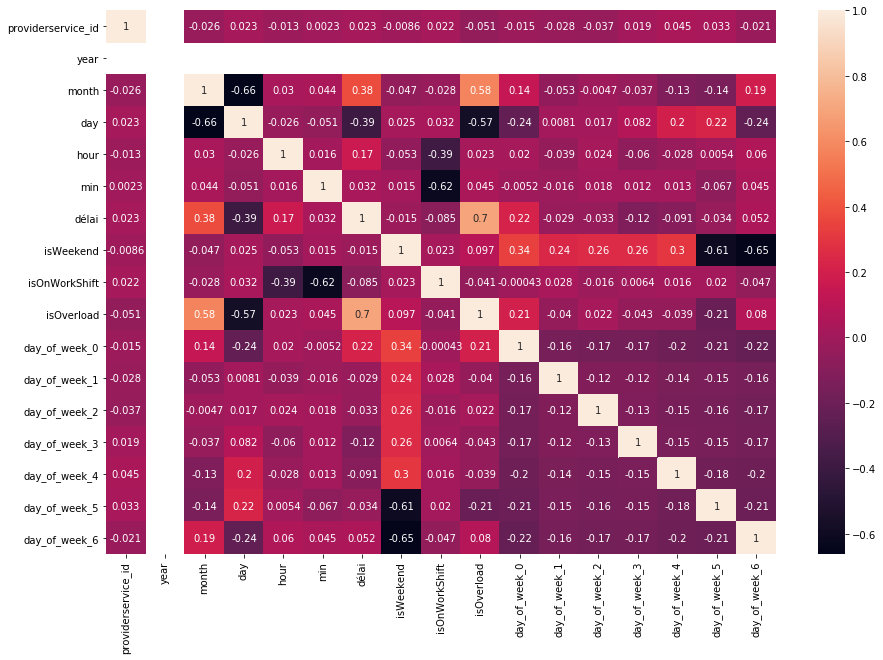

In [206]:
corr_df = df.corr(method='pearson')

plt.figure(figsize=(15, 10))
sns.heatmap(corr_df, annot=True)
plt.show()